# 1. Import Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sb

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
# Special Imports
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from pylab import rcParams

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tbats import BATS, TBATS
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# 2. Import data file

In [2]:
input_data = pd.read_csv("../data/fulldataset.csv", sep = ";")

In [3]:
input_data.head()

,Unnamed: 0,actual,entsoe,bsl_t,brn_t,zrh_t,lug_t,lau_t,gen_t,stg_t,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2014-12-31 23:00:00+00:00,7597.0,7654.0,24.69,19.89,21.08,26.77,27.46,30.65,22.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2015-01-01 00:00:00+00:00,7632.0,7687.0,23.41,18.96,21.66,26.14,27.26,29.86,22.98,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 01:00:00+00:00,7640.0,7696.0,21.45,19.26,21.50,25.75,27.00,29.40,21.82,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 02:00:00+00:00,7391.0,7448.0,20.98,18.51,21.42,25.63,26.36,27.28,22.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 03:00:00+00:00,7333.0,7382.0,20.90,17.26,22.26,24.48,25.75,27.04,22.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
input_data.columns

Index(['Unnamed: 0', 'actual', 'entsoe', 'bsl_t', 'brn_t', 'zrh_t', 'lug_t',
       'lau_t', 'gen_t', 'stg_t', 'luz_t', 'bsl_1', 'bsl_2', 'bsl_3', 'brn_1',
       'brn_2', 'brn_3', 'zrh_1', 'zrh_2', 'zrh_3', 'lug_1', 'lug_2', 'lug_3',
       'lau_1', 'lau_2', 'lau_3', 'gen_1', 'gen_2', 'gen_3', 'stg_1', 'stg_2',
       'stg_3', 'luz_1', 'luz_2', 'luz_3', 'holiday', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [5]:
input_data.shape

(20759, 79)

# 3. Clean data

In [6]:
input_data.rename(columns={"Unnamed: 0": "date"}, inplace=True)

In [7]:
min(input_data["date"]), max(input_data["date"])

('2014-12-31 23:00:00+00:00', '2017-05-16 21:00:00+00:00')

# 4. Important columns

In [8]:
imp_columns = ["date", "actual", "entsoe"]

## 4.1 DateTime Index

In [9]:
dti = pd.date_range(freq='H', start=min(input_data["date"]), end=max(input_data["date"]))
dti

DatetimeIndex(['2014-12-31 23:00:00+00:00', '2015-01-01 00:00:00+00:00',
               '2015-01-01 01:00:00+00:00', '2015-01-01 02:00:00+00:00',
               '2015-01-01 03:00:00+00:00', '2015-01-01 04:00:00+00:00',
               '2015-01-01 05:00:00+00:00', '2015-01-01 06:00:00+00:00',
               '2015-01-01 07:00:00+00:00', '2015-01-01 08:00:00+00:00',
               ...
               '2017-05-16 12:00:00+00:00', '2017-05-16 13:00:00+00:00',
               '2017-05-16 14:00:00+00:00', '2017-05-16 15:00:00+00:00',
               '2017-05-16 16:00:00+00:00', '2017-05-16 17:00:00+00:00',
               '2017-05-16 18:00:00+00:00', '2017-05-16 19:00:00+00:00',
               '2017-05-16 20:00:00+00:00', '2017-05-16 21:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=20807, freq='H')

In [10]:
dataset_1 = input_data.loc[:, imp_columns]
dataset_1.date = pd.to_datetime(dataset_1.date)
dataset_1.index = dataset_1.date
dataset_1.drop(columns=["date"], inplace=True)
dataset_1.head()

,actual,entsoe
date,,
2014-12-31 23:00:00+00:00,7597.0,7654.0
2015-01-01 00:00:00+00:00,7632.0,7687.0
2015-01-01 01:00:00+00:00,7640.0,7696.0
2015-01-01 02:00:00+00:00,7391.0,7448.0
2015-01-01 03:00:00+00:00,7333.0,7382.0


In [11]:
dataset_1 = dataset_1.reindex(dti, method="pad")
dataset_1.head()

,actual,entsoe
2014-12-31 23:00:00+00:00,7597.0,7654.0
2015-01-01 00:00:00+00:00,7632.0,7687.0
2015-01-01 01:00:00+00:00,7640.0,7696.0
2015-01-01 02:00:00+00:00,7391.0,7448.0
2015-01-01 03:00:00+00:00,7333.0,7382.0


# 5. Data Distribution

## 5.1. Actual

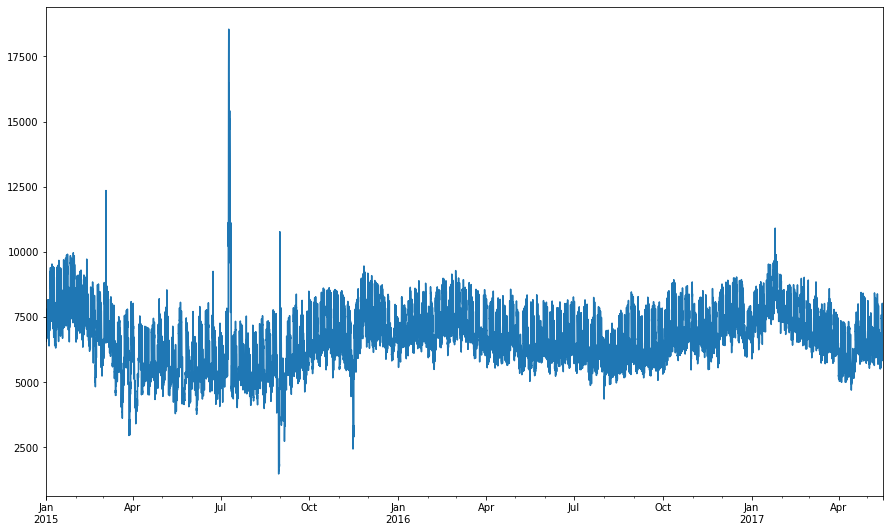

In [12]:
plt.figure(figsize=(15, 9))
dataset_1["actual"].plot()
plt.show()

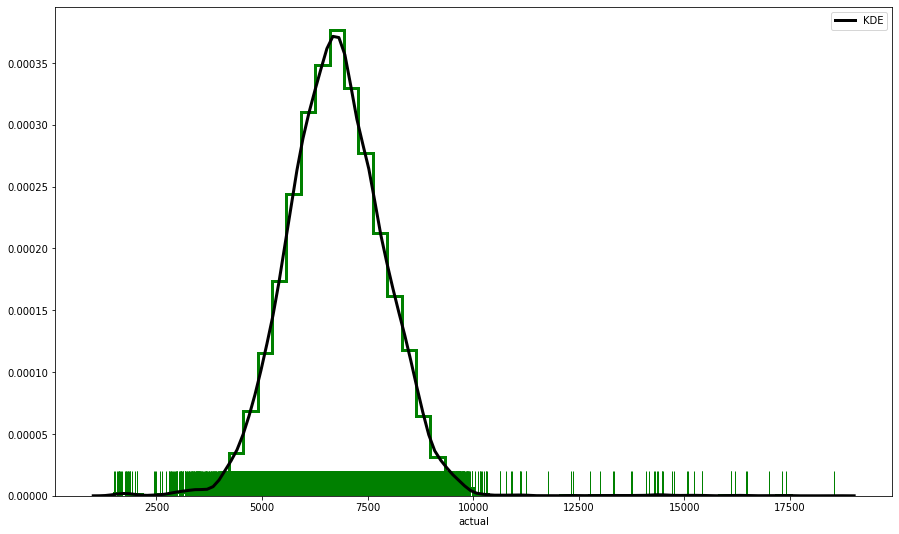

In [13]:
plt.figure(figsize=(15, 9))
sb.distplot(dataset_1["actual"], rug=True, 
            rug_kws={"color": "g"}, kde_kws={"color": "k", "lw": 3, "label": "KDE"}, 
            hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "green"})
plt.show()

## 5.2. Entsoe

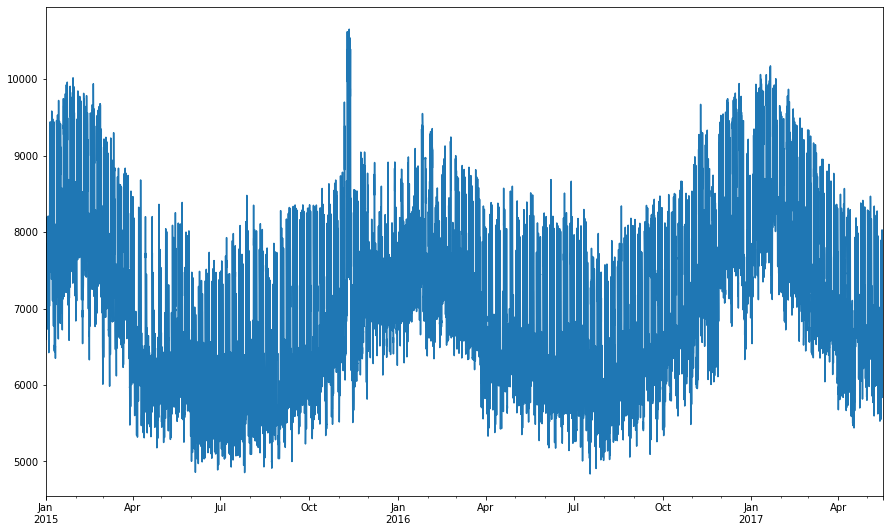

In [14]:
plt.figure(figsize=(15, 9))
dataset_1["entsoe"].plot()
plt.show()

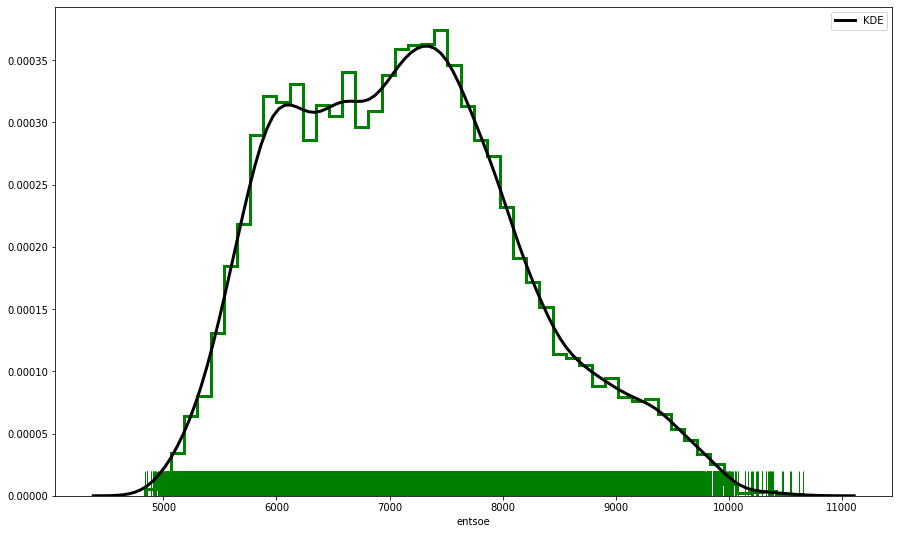

In [15]:
plt.figure(figsize=(15, 9))
sb.distplot(dataset_1["entsoe"], rug=True, 
            rug_kws={"color": "g"}, kde_kws={"color": "k", "lw": 3, "label": "KDE"}, 
            hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "green"})
plt.show()

#### The frequency of observation is 60 minutes.

## 5.3. Skew and Kurtosis

In [16]:
dataset_1["actual"].skew(), dataset_1["actual"].kurtosis()

(0.5052559311367887, 4.520865272212838)

## 5.4. Decomposition

#### We should decompose the components of a Time Series like Trend, Seasonality, and Residuals. We should try to forecast the seasonality component separately. Trend and Residuals should be added together and forecasted. The forecast from the decomposed series should be added back again to get the main forecast.

In [17]:
dataset_1_decomposition = sm.tsa.seasonal_decompose(dataset_1["actual"], model="additive")

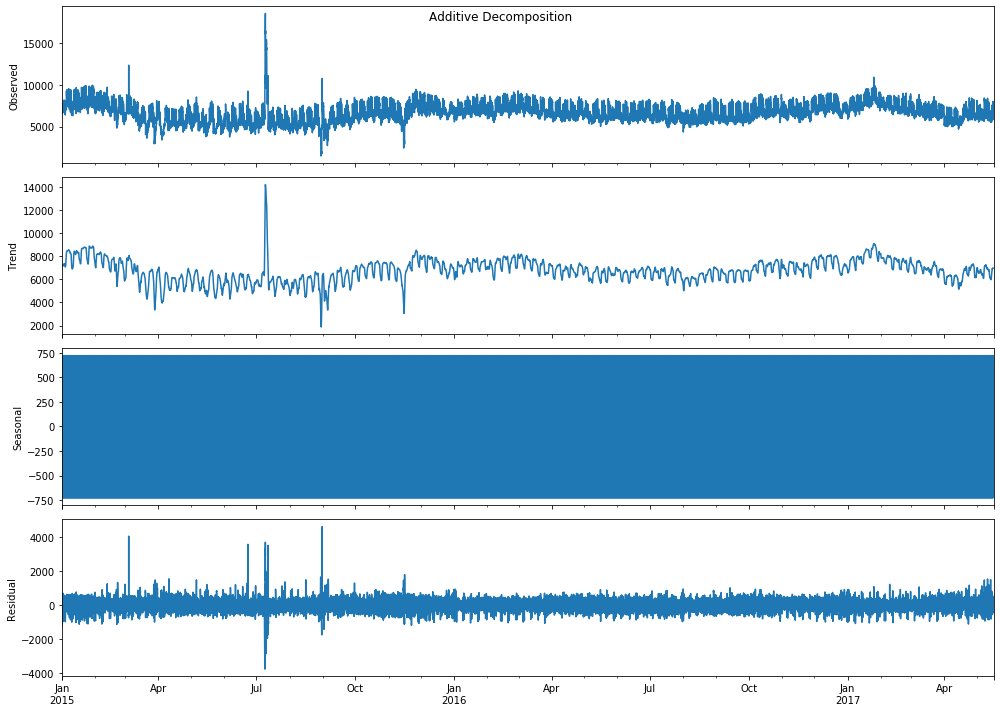

In [18]:
rcParams['figure.figsize'] = 14, 10
dataset_1_decomposition.plot().suptitle('Additive Decomposition')
plt.show()

In [19]:
dataset_1_tr = dataset_1_decomposition.trend + dataset_1_decomposition.resid
dataset_1_tr.fillna(0.0, inplace=True)
dataset_1_tr.head()

2014-12-31 23:00:00+00:00    0.0
2015-01-01 00:00:00+00:00    0.0
2015-01-01 01:00:00+00:00    0.0
2015-01-01 02:00:00+00:00    0.0
2015-01-01 03:00:00+00:00    0.0
Freq: H, Name: actual, dtype: float64

In [20]:
dataset_1_tr.shape

(20807,)

In [21]:
dataset_1_s = dataset_1_decomposition.seasonal
dataset_1_s.fillna(0.0, inplace=True)
dataset_1_s.head()

2014-12-31 23:00:00+00:00   -590.227834
2015-01-01 00:00:00+00:00   -651.598071
2015-01-01 01:00:00+00:00   -657.997344
2015-01-01 02:00:00+00:00   -658.030832
2015-01-01 03:00:00+00:00   -728.457121
Freq: H, Name: actual, dtype: float64

In [22]:
dataset_1_s.shape

(20807,)

# 6. Stationary

## 6.1. Auto-correlation

### 6.1.1. Auto-correlation: Seasonality

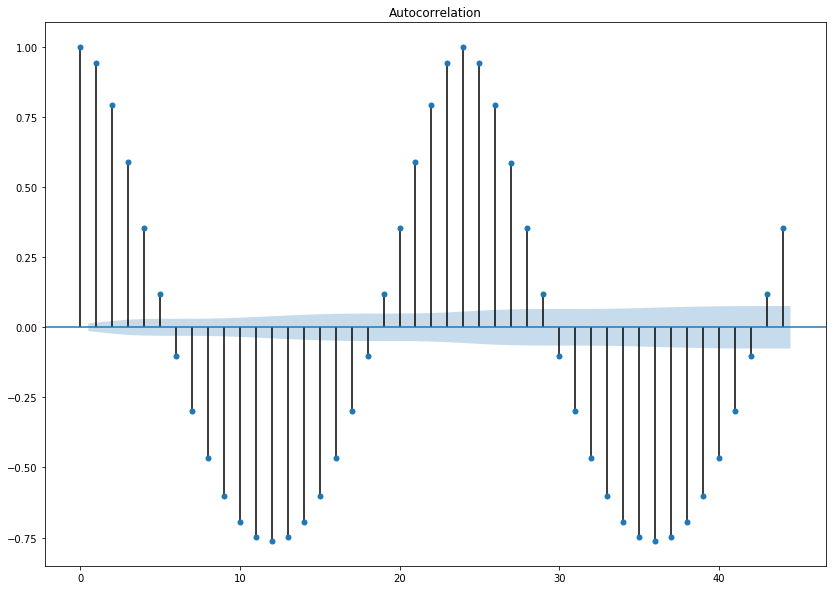

In [23]:
rcParams['figure.figsize'] = 14, 10
plot_acf(dataset_1_s)
plt.show()

### 6.1.2. Auto-correlation: Trend + Residual

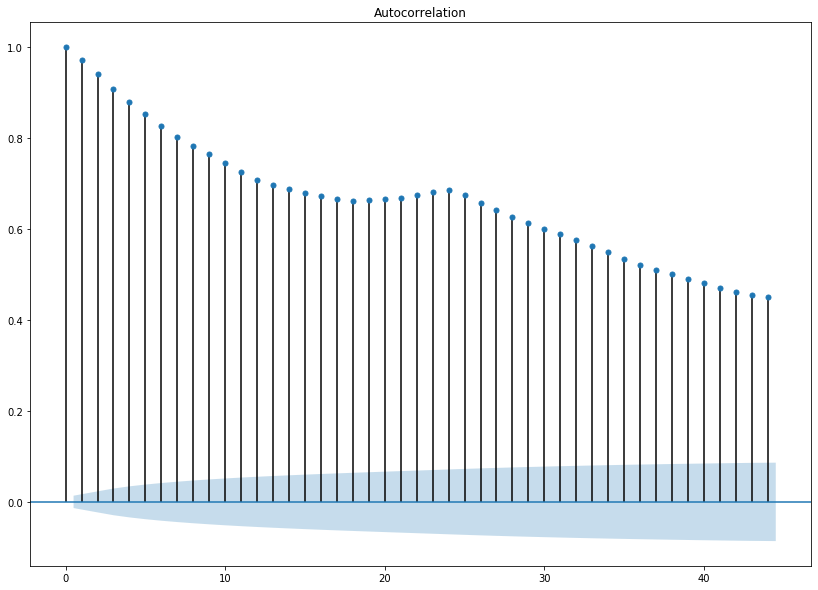

In [24]:
rcParams['figure.figsize'] = 14, 10
plot_acf(dataset_1_tr)
plt.show()

## 6.2. Partial Auto-correlation

### 6.2.1. Partial Auto-correlation: Seasonality

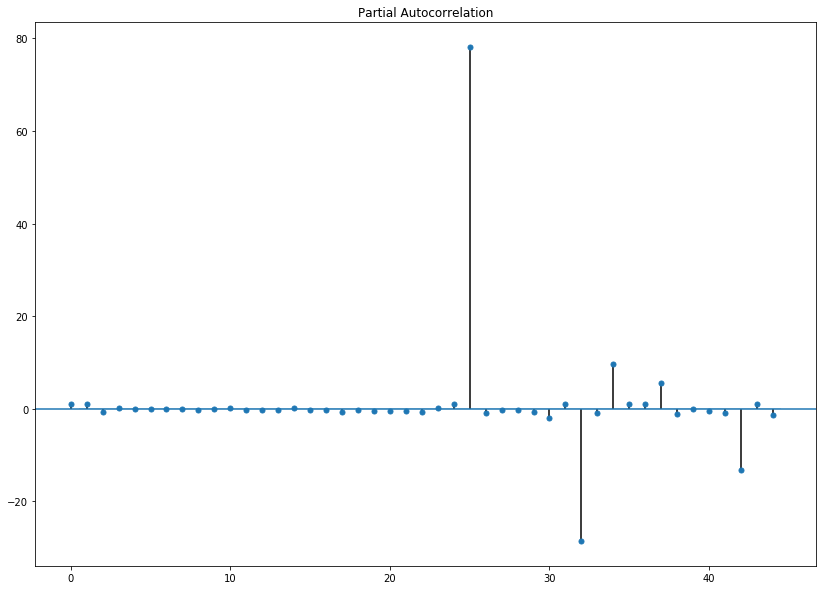

In [25]:
rcParams['figure.figsize'] = 14, 10
plot_pacf(dataset_1_s)
plt.show()

### 6.2.2. Partial Auto-correlation: Trend + Residual

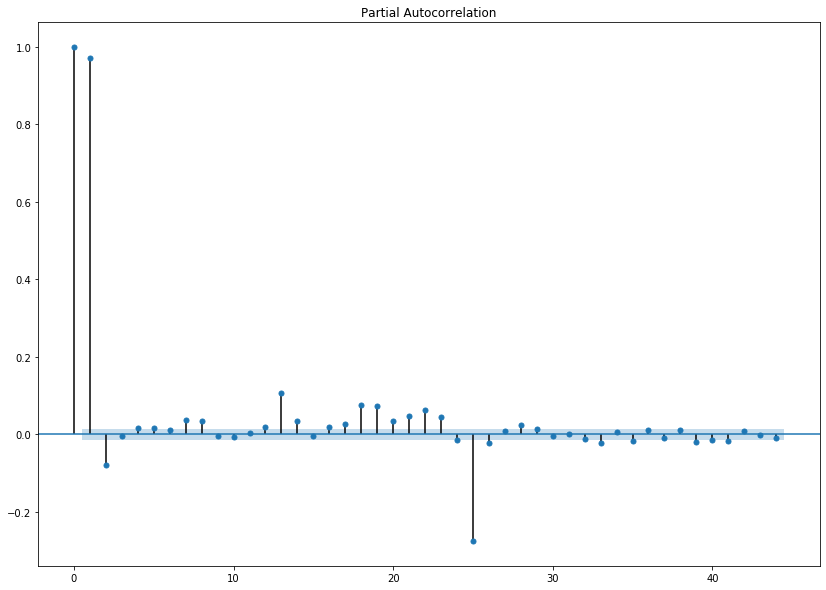

In [26]:
rcParams['figure.figsize'] = 14, 10
plot_pacf(dataset_1_tr)
plt.show()

## 6.3. ADF Test

#### For ADF test the NULL hypothesis is that there is a unit root or the TS is not stationary. A p-value less than 0.05 significance level means we can reject the NULL hypothesis and the TS is stationary.

### 6.3.1. ADF Test: Seasonality

In [27]:
result = adfuller(dataset_1_s.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1655927360333439.8
p-value: 0.0
Critial Values:
   1%, -3.4306650037896427
Critial Values:
   5%, -2.861679220885423
Critial Values:
   10%, -2.566844103424297


### 6.3.2. ADF Test: Trend + Residuals

In [28]:
result = adfuller(dataset_1_tr.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -10.71466701744641
p-value: 3.2645877167275777e-19
Critial Values:
   1%, -3.430665034140582
Critial Values:
   5%, -2.8616792342987867
Critial Values:
   10%, -2.566844110563983


## 6.4. KPSS Test

### 6.4.1. KPSS Test: Seasonality

In [29]:
result = kpss(dataset_1_s.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.054394
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


### 6.4.2. KPSS Test: Trend + Residuals

In [30]:
result = kpss(dataset_1_tr.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 3.080314
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


## 6.5. Lag plot

### 6.5.1. Lag Plot: Seasonality

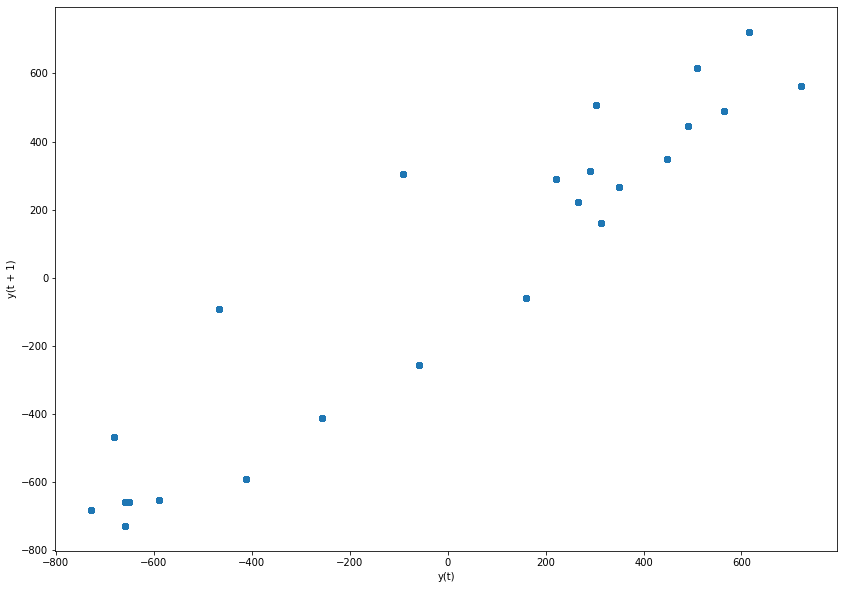

In [31]:
rcParams['figure.figsize'] = 14, 10
pd.plotting.lag_plot(series=dataset_1_s, lag=1)
plt.show()

### 6.5.1. Lag Plot: Trend + Residuals

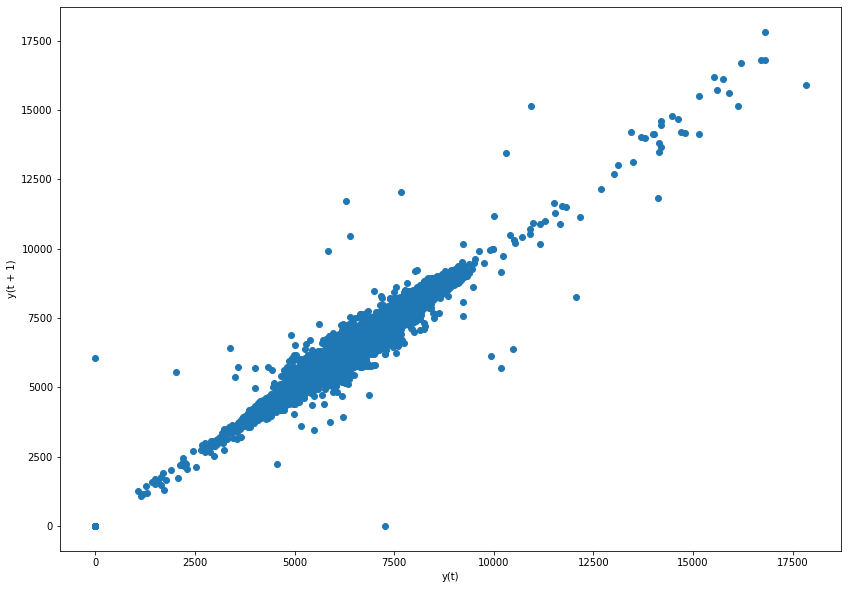

In [32]:
rcParams['figure.figsize'] = 14, 10
pd.plotting.lag_plot(series=dataset_1_tr, lag=1)
plt.show()

# 7. Forecasts